# Solving the Heat Equation with Neural Networks

In [51]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.autograd.functional import hessian, jacobian
from torchviz import make_dot

plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
})

FIGPATH = "../figs/"
FIGSIZE = np.array([4, 3]) * 0.75

sys.path.insert(0, "../src")
from utils import minibatch, heat_eq_analytic

dtype = torch.float
#device = torch.device("cuda:0")
device = torch.device("cpu")

#torch.autograd.set_detect_anomaly(True)

We use a trial function in the form

$$
   g_{trial}(x, t, N) = (1 - t) \sin(\pi x) + x (1 - x)t N
$$

Where $N$ is the output of the neural network to enforce the initial and boundary conditions.

In [52]:
# Trial function
def g_trial(x, t, N):
    return (1 - t) * torch.sin(np.pi * x) + x * (1 - x) * t * N

# Trial function that works with numpy arrays instead of tensors
def g_trial_np(x, t, N):
    return (1 - t) * np.sin(np.pi * x) + x * (1 - x) * t * N

def ode_loss(input_data, output_data):
    """
    Cost function used to evaluate the output of the network
        
    input_data (Tensor): set of (x,t) points where samples are expected along the 0-th axis and x, t
                         as the first and second entries on the 1st axis respectively.
    
    output_data (Tensor): Output of the Neural network (N), where each sample is expected along the 0-th
                          axis in order corresponding to the input_data
    """
    loss = 0
    
    for i in range(input_data.size(0)):
        Jx, Jt, Jn = jacobian(g_trial, (input_data[i,0], input_data[i,1], output_data[i]),create_graph=True)
        Hx, Ht, Hn = hessian(g_trial, (input_data[i,0], input_data[i,1], output_data[i]),create_graph=True)
        loss = loss + (Jt - Hx[0]).pow(2)
    
    return loss / input_data.size(0)

We then define some utility functions used to generate plots for the report in an efficient manner.

In [59]:
def plot_pde(model, grid_size=100, fn = "tmp"):
    """
    Plots the output of a trained pytorch model on an equispaced grid in the domain of interest    
    """
    
    # Set up plotting data
    x = np.linspace(0,1,grid_size, dtype=np.float)
    t = np.linspace(0,1,grid_size, dtype=np.float)
    x, t = np.meshgrid(x, t) 
    x_flat = x.flatten()
    t_flat = t.flatten()
    X = np.concatenate((x_flat.reshape(-1,1), t_flat.reshape(-1, 1)), axis=1)

    # Convert to pytorch tensors
    xp = torch.from_numpy(X)
    xp = xp.to(dtype).to(device)
    
    # Evaluate model
    model.eval()    
    N_pred = model(xp)
    N_pred = N_pred.detach().numpy()
    N_pred = N_pred.reshape(grid_size, grid_size)

    g = g_trial_np(x, t, N_pred)

    fig, ax = plt.subplots(figsize=FIGSIZE)
    #cf = ax.pcolormesh(x, t, g, cmap=plt.get_cmap("inferno"))
    cf = ax.pcolormesh(x, t, g, cmap=plt.get_cmap("jet"))
    fig.colorbar(cf, ax=ax)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$t$")
    
    plt.savefig(FIGPATH + fn + ".pdf")
    
    return
    
def plot_error(model, x, t, fn = "tmp"):
    """"
    Plots the absolute error of a trained pytorch model for a given set of x, t points. 
    Also computes the mean absolute error and displays it on the plot.
    """
    
    x, t = np.meshgrid(x, t) 
    x_flat = x.flatten()
    t_flat = t.flatten()
    X = np.concatenate((x_flat.reshape(-1,1), t_flat.reshape(-1, 1)), axis=1)
    
    # Convert to pytorch tensors
    xp = torch.from_numpy(X)
    xp = xp.to(dtype).to(device)
    
    # Evaluate model
    model.eval()    
    N_pred = model(xp)
    N_pred = N_pred.detach().numpy()
    N_pred = N_pred.reshape(x.shape)
    
    g_model = g_trial_np(x, t, N_pred)
    g_analytic = heat_eq_analytic(x, t)
    
    #square_error = (g_model - g_analytic)**2
    #MSE = np.mean(square_error.flatten())
    
    relative_error = np.abs(g_model - g_analytic) 
    MAE = np.mean(relative_error.flatten())
    
    fig, ax = plt.subplots(figsize=FIGSIZE)
    #cf = ax.pcolormesh(x, t, g, cmap=plt.get_cmap("inferno"))
    #cf = ax.pcolormesh(x, t, relative_error, cmap=plt.get_cmap("inferno"),label="MSE")
    cf = ax.pcolormesh(x, t, relative_error, cmap=plt.get_cmap("jet"),label="MSE")
    cmap = fig.colorbar(cf, ax=ax)
    cmap.set_label("Absolute Error")
    t = ax.annotate("MAE = %.2e" % MAE, xy=(0.05 * np.amax(x_flat), 0.85 * np.amax(t_flat)))
    t.set_bbox(dict(facecolor='white', alpha=0.5))
    ax.set_xlabel("$x$")
    ax.set_ylabel("$t$")
    
    plt.savefig(FIGPATH + fn + ".pdf")
    
    return

def generate_trainingdata(x, t):
    """
    Used to convert a set x,t numpy arrays to a pytorch tensor where each set of points
    goes down along the 0th axis and x, t pairs go in order along the 1st axis i.e: x[sample][coordinate]
    """
    x, t = np.meshgrid(x, t) 
    x = x.flatten()
    t = t.flatten()
    X = np.concatenate((x.reshape(-1,1), t.reshape(-1, 1)), axis=1)

    # Convert to pytorch tensors
    x = torch.from_numpy(X)
    x = x.to(dtype).to(device)
    x.requires_grad = True
    return x

# Training on a 11x11 Grid

We first train a model on an equispaced 11x11 grid using a FFNN with 2 hidden layers with 100 neurons each and the ReLU activation function.

In [4]:
# Set up data in numpy
grid_size = 11

x = generate_trainingdata(
    x = np.linspace(0,1,grid_size, dtype=np.float),
    t = np.linspace(0,1,grid_size, dtype=np.float)
)

# Shape of the network
num_points, input_dim = x.shape
hidden_neurons = 100
output_dim = 1

# Set up the model
learning_rate = 0.002
N_minibatches = int(num_points / 16)

model_10 = torch.nn.Sequential(
    torch.nn.Linear(input_dim, hidden_neurons),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_neurons, hidden_neurons),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_neurons, hidden_neurons),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_neurons, hidden_neurons),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_neurons, output_dim),
)

# Use the ADAM optimization algorithm with standard parameters
optimizer_10 = torch.optim.Adam(model_10.parameters(), lr=learning_rate)

# Keep track of the total number of epochs the network has been trained for as well as a
# cumulative record of the loss wrt to each epoch.
TOT_EPOCHS_10 = 0
loss_arr_tot_10 = np.empty(0, dtype=np.float)
epoch_arr_tot_10 = np.empty(0, dtype=np.float)

Now that the model has been set up, the network may be trained by running the cell below. If unhappy with the current results, you may simply rerun the cell adjusting the EPOCHS variable if so desired. Further, the loss wrt the epochs is kept track of by appending the loss of the current run (loss_arr_curr_10) to the (loss_arr_tot_10) array that we defined previously, thus the complete history of the loss is kept throughout.

Note that the loss function is evaluated on the entire dataset inbetween each epoch, but the actual training is performed using minibatches!

In [5]:
EPOCHS = 10_000

loss_arr_curr_10 = np.empty(EPOCHS, dtype=np.float)
epoch_arr_curr_10 = np.empty(EPOCHS, dtype=np.float)

model_10.train()
for epoch in range(EPOCHS):
    # Pick out a new set of minibatches
    mb = minibatch(num_points, N_minibatches)
    for i in range(N_minibatches):
        N_output = model_10(x[mb[i]])        # Forward pass
        loss = ode_loss(x[mb[i]], N_output)  # Compute loss
        optimizer_10.zero_grad()             # Zero gradients from prev itter
        loss.backward()                      # Backward pass
        optimizer_10.step()                  # Optimize with ADAM
        
    # Compute loss of entire sample
    N_output = model_10(x) 
    loss = ode_loss(x, N_output)
    if epoch % 100 == 0:
        print(f"{TOT_EPOCHS_10 + epoch}: loss = ",loss) 
    loss_arr_curr_10[epoch] = loss
    epoch_arr_curr_10[epoch] = TOT_EPOCHS_10 + epoch

TOT_EPOCHS_10 += EPOCHS    
loss_arr_tot_10 = np.append(loss_arr_tot_10, loss_arr_curr_10)
epoch_arr_tot_10 = np.append(epoch_arr_tot_10, epoch_arr_curr_10)

0: loss =  tensor([10.1863], grad_fn=<DivBackward0>)
100: loss =  tensor([0.0128], grad_fn=<DivBackward0>)
200: loss =  tensor([0.0037], grad_fn=<DivBackward0>)
300: loss =  tensor([0.0044], grad_fn=<DivBackward0>)
400: loss =  tensor([0.0011], grad_fn=<DivBackward0>)
500: loss =  tensor([0.0035], grad_fn=<DivBackward0>)
600: loss =  tensor([0.0009], grad_fn=<DivBackward0>)
700: loss =  tensor([0.0008], grad_fn=<DivBackward0>)
800: loss =  tensor([0.0323], grad_fn=<DivBackward0>)
900: loss =  tensor([0.0011], grad_fn=<DivBackward0>)
1000: loss =  tensor([0.0004], grad_fn=<DivBackward0>)
1100: loss =  tensor([0.0115], grad_fn=<DivBackward0>)
1200: loss =  tensor([0.0019], grad_fn=<DivBackward0>)
1300: loss =  tensor([0.0010], grad_fn=<DivBackward0>)
1400: loss =  tensor([0.0216], grad_fn=<DivBackward0>)
1500: loss =  tensor([0.0002], grad_fn=<DivBackward0>)
1600: loss =  tensor([0.0099], grad_fn=<DivBackward0>)
1700: loss =  tensor([0.0008], grad_fn=<DivBackward0>)
1800: loss =  tensor(

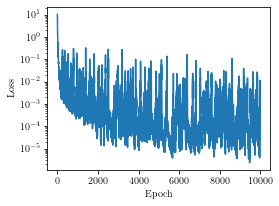

In [35]:
plt.figure(figsize=FIGSIZE)
plt.semilogy(epoch_arr_tot_10, loss_arr_tot_10)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.savefig(FIGPATH+"PDE_RELU_LOSS.pdf")

<ipython-input-52-cc77b48b28ff>:41: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cf = ax.pcolormesh(x, t, g, cmap=plt.get_cmap("jet"))
<ipython-input-52-cc77b48b28ff>:78: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cf = ax.pcolormesh(x, t, relative_error, cmap=plt.get_cmap("jet"),label="MSE")


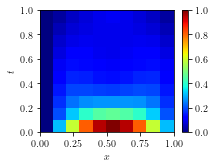

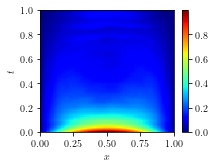

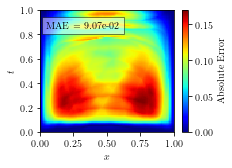

In [53]:
plot_pde(model_10, 11, fn="PDE_RELU_10_10x1000")
plot_pde(model_10, 100, fn="PDE_RELU_10_100x100")
plot_error(model_10, np.linspace(0,1, 100), np.linspace(0,1,100), fn="PDE_RELU_10_ERR")

In [8]:
#make_dot(N_output).render("output_graph", format="pdf")
#make_dot(loss).render("loss_graph", format="pdf")

# Training on a 100x100 Grid

We then repeat the same procedure as above for a $[100\times100]$ grid. Note that the pytorch model is stored in a different model, thus one may if so desired go back and forth between training different networks by rerunning the training cells without overwriting other models. This does require re-generate the appropriate input data however (by running the cell below, for this particular model)

Otherwise, everyhing is exactly the same as above.

In [9]:
# Set up data in numpy
grid_size = 100

x = generate_trainingdata(
    x = np.linspace(0,1,grid_size, dtype=np.float),
    t = np.linspace(0,1,grid_size, dtype=np.float)
)

In [10]:
# Shape of the network
num_points, input_dim = x.shape
hidden_neurons = 20
output_dim = 1

# Set up the model
learning_rate = 0.002
N_minibatches = int(num_points / 16)

model_100 = torch.nn.Sequential(
    torch.nn.Linear(input_dim, hidden_neurons),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_neurons, hidden_neurons),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_neurons, hidden_neurons),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_neurons, hidden_neurons),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_neurons, output_dim),
)
optimizer_100 = torch.optim.Adam(model_100.parameters(), lr=learning_rate)

TOT_EPOCHS_100 = 0

loss_arr_tot_100 = np.empty(0, dtype=np.float)
epoch_arr_tot_100 = np.empty(0, dtype=np.float)

print("Number of minibatches = ", N_minibatches)

Number of minibatches =  625


0: loss =  tensor([0.4878], grad_fn=<DivBackward0>)
1: loss =  tensor([0.2487], grad_fn=<DivBackward0>)
2: loss =  tensor([0.1245], grad_fn=<DivBackward0>)
3: loss =  tensor([0.0934], grad_fn=<DivBackward0>)
4: loss =  tensor([0.0899], grad_fn=<DivBackward0>)
5: loss =  tensor([0.0746], grad_fn=<DivBackward0>)
6: loss =  tensor([0.0730], grad_fn=<DivBackward0>)
7: loss =  tensor([0.0628], grad_fn=<DivBackward0>)
8: loss =  tensor([0.0698], grad_fn=<DivBackward0>)
9: loss =  tensor([0.0498], grad_fn=<DivBackward0>)
10: loss =  tensor([0.0413], grad_fn=<DivBackward0>)
11: loss =  tensor([0.0382], grad_fn=<DivBackward0>)
12: loss =  tensor([0.0365], grad_fn=<DivBackward0>)
13: loss =  tensor([0.0388], grad_fn=<DivBackward0>)
14: loss =  tensor([0.0291], grad_fn=<DivBackward0>)
15: loss =  tensor([0.0225], grad_fn=<DivBackward0>)
16: loss =  tensor([0.0270], grad_fn=<DivBackward0>)
17: loss =  tensor([0.0257], grad_fn=<DivBackward0>)
18: loss =  tensor([0.0294], grad_fn=<DivBackward0>)
19:

Text(0.5, 0, 'Epoch')

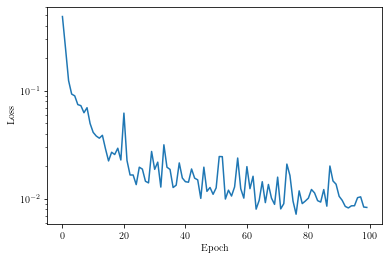

In [11]:
EPOCHS = 100

loss_arr_curr_100 = np.empty(EPOCHS, dtype=np.float)
epoch_arr_curr_100 = np.empty(EPOCHS, dtype=np.float)

model_100.train()
for epoch in range(EPOCHS):
    # Pick out a new set of minibatches
    mb = minibatch(num_points, N_minibatches)
    for i in range(N_minibatches):
        N_output = model_100(x[mb[i]])           # Forward pass
        loss = ode_loss(x[mb[i]], N_output)  # Compute loss
        optimizer_100.zero_grad()                # Zero gradients from prev itter
        loss.backward()                      # Backward pass
        optimizer_100.step()                     # Optimize with ADAM
        
    # Compute loss of entire sample
    N_output = model_100(x) 
    loss = ode_loss(x, N_output)
    print(f"{TOT_EPOCHS_100 + epoch}: loss = ",loss) 
    loss_arr_curr_100[epoch] = loss
    epoch_arr_curr_100[epoch] = TOT_EPOCHS_100 + epoch

TOT_EPOCHS_100 += EPOCHS    
loss_arr_tot_100 = np.append(loss_arr_tot_100, loss_arr_curr_100)
epoch_arr_tot_100 = np.append(epoch_arr_tot_100, epoch_arr_curr_100)

plt.semilogy(epoch_arr_tot_100, loss_arr_tot_100)
plt.ylabel("Loss")
plt.xlabel("Epoch")

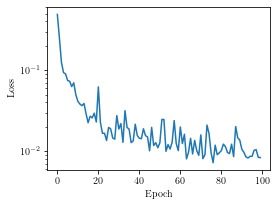

In [37]:
plt.figure(figsize=FIGSIZE)
plt.semilogy(epoch_arr_tot_100, loss_arr_tot_100)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.savefig(FIGPATH+"PDE_RELU_LOSS_100.pdf")

<ipython-input-52-cc77b48b28ff>:41: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cf = ax.pcolormesh(x, t, g, cmap=plt.get_cmap("jet"))
<ipython-input-52-cc77b48b28ff>:78: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cf = ax.pcolormesh(x, t, relative_error, cmap=plt.get_cmap("jet"),label="MSE")


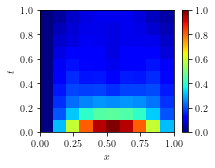

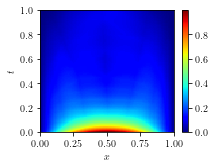

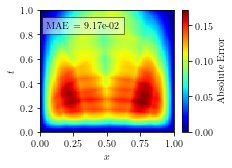

In [54]:
plot_pde(model=model_100, grid_size=11, fn="PDE_RELU_100_10x10")
plot_pde(model=model_100, grid_size=100, fn="PDE_RELU_100_100x100")
plot_error(model_100, np.linspace(0,1, 100), np.linspace(0,1,100), fn="PDE_RELU_100_ERR")

surprisingly, the results very similar to the low resolution model!

# Random sampling

We do the same procedure for a $[11\times11]$ grid, but with random sampling!

In [14]:
# Set up data in numpy
grid_size = 11

x = generate_trainingdata(
    x = np.random.uniform(0,1,grid_size),
    t = np.random.uniform(0,1,grid_size)
)

In [15]:
# Shape of the network
num_points, input_dim = x.shape
hidden_neurons = 100
output_dim = 1

# Set up the model
learning_rate = 0.002
N_minibatches = int(num_points / 16)

model_rand = torch.nn.Sequential(
    torch.nn.Linear(input_dim, hidden_neurons),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_neurons, hidden_neurons),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_neurons, hidden_neurons),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_neurons, hidden_neurons),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_neurons, output_dim),
)
optimizer_rand = torch.optim.Adam(model_rand.parameters(), lr=learning_rate)

TOT_EPOCHS_rand = 0

loss_arr_tot_rand = np.empty(0, dtype=np.float)
epoch_arr_tot_rand = np.empty(0, dtype=np.float)

print("Number of minibatches = ", N_minibatches)

Number of minibatches =  7


0: loss =  tensor([16.2920], grad_fn=<DivBackward0>)
100: loss =  tensor([0.0090], grad_fn=<DivBackward0>)
200: loss =  tensor([0.0069], grad_fn=<DivBackward0>)
300: loss =  tensor([0.0044], grad_fn=<DivBackward0>)
400: loss =  tensor([0.0050], grad_fn=<DivBackward0>)
500: loss =  tensor([0.0023], grad_fn=<DivBackward0>)
600: loss =  tensor([0.0003], grad_fn=<DivBackward0>)
700: loss =  tensor([0.0004], grad_fn=<DivBackward0>)
800: loss =  tensor([0.0005], grad_fn=<DivBackward0>)
900: loss =  tensor([0.0005], grad_fn=<DivBackward0>)
1000: loss =  tensor([0.0330], grad_fn=<DivBackward0>)
1100: loss =  tensor([0.0001], grad_fn=<DivBackward0>)
1200: loss =  tensor([0.0005], grad_fn=<DivBackward0>)
1300: loss =  tensor([0.0003], grad_fn=<DivBackward0>)
1400: loss =  tensor([0.0012], grad_fn=<DivBackward0>)
1500: loss =  tensor([0.0058], grad_fn=<DivBackward0>)
1600: loss =  tensor([0.0015], grad_fn=<DivBackward0>)
1700: loss =  tensor([0.0003], grad_fn=<DivBackward0>)
1800: loss =  tensor(

Text(0.5, 0, 'Epoch')

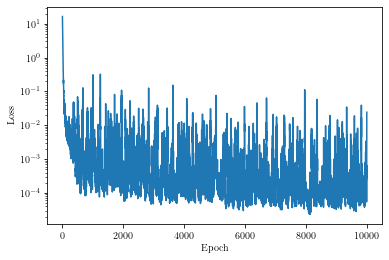

In [16]:
EPOCHS = 10_000

loss_arr_curr_rand = np.empty(EPOCHS, dtype=np.float)
epoch_arr_curr_rand = np.empty(EPOCHS, dtype=np.float)

model_rand.train()
for epoch in range(EPOCHS):
    # Pick out a new set of minibatches
    mb = minibatch(num_points, N_minibatches)
    for i in range(N_minibatches):
        N_output = model_rand(x[mb[i]])      # Forward pass
        loss = ode_loss(x[mb[i]], N_output)  # Compute loss
        optimizer_rand.zero_grad()           # Zero gradients from prev itter
        loss.backward()                      # Backward pass
        optimizer_rand.step()                # Optimize with ADAM
        
    # Compute loss of entire sample
    N_output = model_rand(x) 
    loss = ode_loss(x, N_output)
    if epoch % 100 == 0:
        print(f"{TOT_EPOCHS_rand + epoch}: loss = ",loss) 
    loss_arr_curr_rand[epoch] = loss
    epoch_arr_curr_rand[epoch] = TOT_EPOCHS_rand + epoch

TOT_EPOCHS_rand += EPOCHS    
loss_arr_tot_rand = np.append(loss_arr_tot_rand, loss_arr_curr_rand)
epoch_arr_tot_rand = np.append(epoch_arr_tot_rand, epoch_arr_curr_rand)

plt.semilogy(epoch_arr_tot_rand, loss_arr_tot_rand)
plt.ylabel("Loss")
plt.xlabel("Epoch")

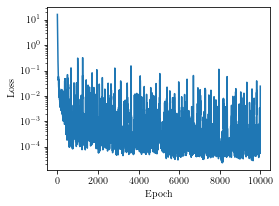

In [39]:
plt.figure(figsize=FIGSIZE)
plt.semilogy(epoch_arr_tot_rand, loss_arr_tot_rand)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.savefig(FIGPATH+"PDE_RELU_LOSS_RAND.pdf")

<ipython-input-52-cc77b48b28ff>:41: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cf = ax.pcolormesh(x, t, g, cmap=plt.get_cmap("jet"))
<ipython-input-52-cc77b48b28ff>:78: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cf = ax.pcolormesh(x, t, relative_error, cmap=plt.get_cmap("jet"),label="MSE")


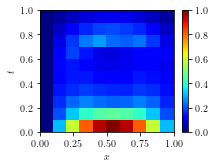

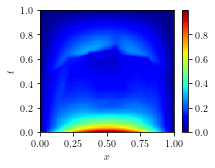

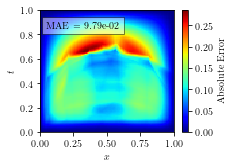

In [55]:
plot_pde(model=model_rand, grid_size=11, fn="PDE_RELU_RAND_10x10")
plot_pde(model=model_rand, grid_size=100, fn="PDE_RELU_RAND_100x100")
plot_error(model_rand, np.linspace(0,1, 100), np.linspace(0,1,100),fn="PDE_RELU_RAND_ERR")

# Testing different activations

Lastly, we once again repeat the process to test Sigmoid and $\tanh$ activation functions in the hidden layers on low resolution $[11\times11]$ training sets

## Sigmoid

In [19]:
# Set reference to the appropriate activation function here such that it may easily be changed with ease
activation_function = torch.nn.Sigmoid()

# Set up data in numpy
grid_size = 11

x = generate_trainingdata(
    x = np.linspace(0,1,grid_size, dtype=np.float),
    t = np.linspace(0,1,grid_size, dtype=np.float)
)

# Shape of the network
num_points, input_dim = x.shape
hidden_neurons = 100
output_dim = 1

# Set up the model
learning_rate = 0.002
N_minibatches = int(num_points / 16)

model_sigmoid = torch.nn.Sequential(
    torch.nn.Linear(input_dim, hidden_neurons),
    activation_function,
    torch.nn.Linear(hidden_neurons, hidden_neurons),
    activation_function,
    torch.nn.Linear(hidden_neurons, hidden_neurons),
    activation_function,
    torch.nn.Linear(hidden_neurons, hidden_neurons),
    activation_function,
    torch.nn.Linear(hidden_neurons, output_dim),
)
optimizer_sigmoid = torch.optim.Adam(model_sigmoid.parameters(), lr=learning_rate)

TOT_EPOCHS_sigmoid = 0

loss_arr_tot_sigmoid = np.empty(0, dtype=np.float)
epoch_arr_tot_sigmoid = np.empty(0, dtype=np.float)

0: loss =  tensor([10.0149], grad_fn=<DivBackward0>)
100: loss =  tensor([2.0278], grad_fn=<DivBackward0>)
200: loss =  tensor([1.5893], grad_fn=<DivBackward0>)
300: loss =  tensor([1.2502], grad_fn=<DivBackward0>)
400: loss =  tensor([1.2316], grad_fn=<DivBackward0>)
500: loss =  tensor([1.1392], grad_fn=<DivBackward0>)
600: loss =  tensor([0.6408], grad_fn=<DivBackward0>)
700: loss =  tensor([0.3120], grad_fn=<DivBackward0>)
800: loss =  tensor([0.2448], grad_fn=<DivBackward0>)
900: loss =  tensor([0.1791], grad_fn=<DivBackward0>)
1000: loss =  tensor([0.1543], grad_fn=<DivBackward0>)
1100: loss =  tensor([0.0564], grad_fn=<DivBackward0>)
1200: loss =  tensor([0.0516], grad_fn=<DivBackward0>)
1300: loss =  tensor([0.0215], grad_fn=<DivBackward0>)
1400: loss =  tensor([0.0264], grad_fn=<DivBackward0>)
1500: loss =  tensor([0.0106], grad_fn=<DivBackward0>)
1600: loss =  tensor([0.0159], grad_fn=<DivBackward0>)
1700: loss =  tensor([0.0203], grad_fn=<DivBackward0>)
1800: loss =  tensor(

Text(0.5, 0, 'Epoch')

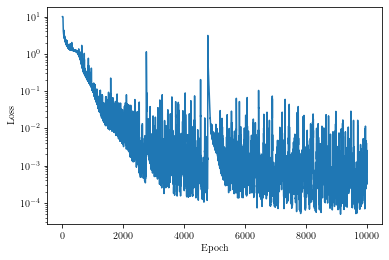

In [20]:
EPOCHS = 10_000

loss_arr_curr_sigmoid = np.empty(EPOCHS, dtype=np.float)
epoch_arr_curr_sigmoid = np.empty(EPOCHS, dtype=np.float)

model_sigmoid.train()
for epoch in range(EPOCHS):
    # Pick out a new set of minibatches
    mb = minibatch(num_points, N_minibatches)
    for i in range(N_minibatches):
        N_output = model_sigmoid(x[mb[i]])           # Forward pass
        loss = ode_loss(x[mb[i]], N_output)  # Compute loss
        optimizer_sigmoid.zero_grad()                # Zero gradients from prev itter
        loss.backward()                      # Backward pass
        optimizer_sigmoid.step()                     # Optimize with ADAM
        
    # Compute loss of entire sample
    N_output = model_sigmoid(x) 
    loss = ode_loss(x, N_output)
    if epoch % 100 == 0:
        print(f"{TOT_EPOCHS_sigmoid + epoch}: loss = ",loss) 
    loss_arr_curr_sigmoid[epoch] = loss
    epoch_arr_curr_sigmoid[epoch] = TOT_EPOCHS_sigmoid + epoch

TOT_EPOCHS_sigmoid += EPOCHS    
loss_arr_tot_sigmoid = np.append(loss_arr_tot_sigmoid, loss_arr_curr_sigmoid)
epoch_arr_tot_sigmoid = np.append(epoch_arr_tot_sigmoid, epoch_arr_curr_sigmoid)

plt.semilogy(epoch_arr_tot_sigmoid, loss_arr_tot_sigmoid)
plt.ylabel("Loss")
plt.xlabel("Epoch")

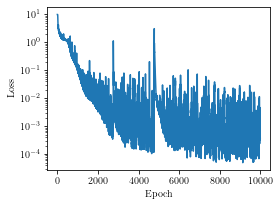

In [41]:
plt.figure(figsize=FIGSIZE)
plt.semilogy(epoch_arr_tot_sigmoid, loss_arr_tot_sigmoid)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.savefig(FIGPATH+"PDE_SIG_LOSS.pdf")

<ipython-input-52-cc77b48b28ff>:41: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cf = ax.pcolormesh(x, t, g, cmap=plt.get_cmap("jet"))
<ipython-input-52-cc77b48b28ff>:78: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cf = ax.pcolormesh(x, t, relative_error, cmap=plt.get_cmap("jet"),label="MSE")


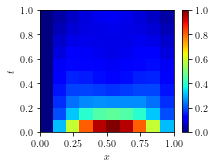

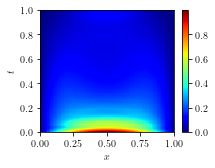

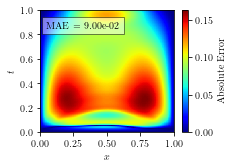

In [56]:
plot_pde(model=model_sigmoid, grid_size=11, fn="PDE_SIG_10x10")
plot_pde(model=model_sigmoid, grid_size=100, fn="PDE_SIG_100x100")
plot_error(model_sigmoid, np.linspace(0,1, 200), np.linspace(0,1,200), fn="PDE_SIG_ERR")

## Tanh

In [23]:
activation_function = torch.nn.Tanh()

# Set up data in numpy
grid_size = 11

x = generate_trainingdata(
    x = np.linspace(0,1,grid_size, dtype=np.float),
    t = np.linspace(0,1,grid_size, dtype=np.float)
)

# Shape of the network
num_points, input_dim = x.shape
hidden_neurons = 100
output_dim = 1

# Set up the model
learning_rate = 0.002
N_minibatches = int(num_points / 16)

model_tanh = torch.nn.Sequential(
    torch.nn.Linear(input_dim, hidden_neurons),
    activation_function,
    torch.nn.Linear(hidden_neurons, hidden_neurons),
    activation_function,
    torch.nn.Linear(hidden_neurons, hidden_neurons),
    activation_function,
    torch.nn.Linear(hidden_neurons, hidden_neurons),
    activation_function,
    torch.nn.Linear(hidden_neurons, output_dim),
)
optimizer_tanh = torch.optim.Adam(model_tanh.parameters(), lr=learning_rate)

TOT_EPOCHS_tanh = 0

loss_arr_tot_tanh = np.empty(0, dtype=np.float)
epoch_arr_tot_tanh = np.empty(0, dtype=np.float)



0: loss =  tensor([9.8595], grad_fn=<DivBackward0>)
100: loss =  tensor([0.1699], grad_fn=<DivBackward0>)
200: loss =  tensor([0.0121], grad_fn=<DivBackward0>)
300: loss =  tensor([0.0037], grad_fn=<DivBackward0>)
400: loss =  tensor([0.0051], grad_fn=<DivBackward0>)
500: loss =  tensor([0.0779], grad_fn=<DivBackward0>)
600: loss =  tensor([0.0022], grad_fn=<DivBackward0>)
700: loss =  tensor([0.0047], grad_fn=<DivBackward0>)
800: loss =  tensor([0.0188], grad_fn=<DivBackward0>)
900: loss =  tensor([0.0578], grad_fn=<DivBackward0>)
1000: loss =  tensor([0.0047], grad_fn=<DivBackward0>)
1100: loss =  tensor([0.0068], grad_fn=<DivBackward0>)
1200: loss =  tensor([0.0053], grad_fn=<DivBackward0>)
1300: loss =  tensor([0.0038], grad_fn=<DivBackward0>)
1400: loss =  tensor([0.0167], grad_fn=<DivBackward0>)
1500: loss =  tensor([0.0025], grad_fn=<DivBackward0>)
1600: loss =  tensor([0.0058], grad_fn=<DivBackward0>)
1700: loss =  tensor([0.1059], grad_fn=<DivBackward0>)
1800: loss =  tensor([

Text(0.5, 0, 'Epoch')

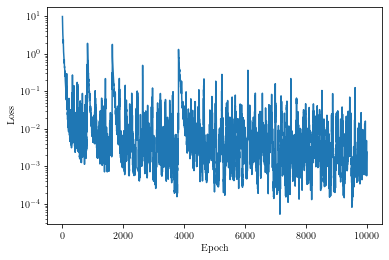

In [24]:
EPOCHS = 10_000

loss_arr_curr_tanh = np.empty(EPOCHS, dtype=np.float)
epoch_arr_curr_tanh = np.empty(EPOCHS, dtype=np.float)

model_tanh.train()
for epoch in range(EPOCHS):
    # Pick out a new set of minibatches
    mb = minibatch(num_points, N_minibatches)
    for i in range(N_minibatches):
        N_output = model_tanh(x[mb[i]])           # Forward pass
        loss = ode_loss(x[mb[i]], N_output)  # Compute loss
        optimizer_tanh.zero_grad()                # Zero gradients from prev itter
        loss.backward()                      # Backward pass
        optimizer_tanh.step()                     # Optimize with ADAM
        
    # Compute loss of entire sample
    N_output = model_tanh(x) 
    loss = ode_loss(x, N_output)
    if epoch % 100 == 0:
        print(f"{TOT_EPOCHS_tanh + epoch}: loss = ",loss) 
    loss_arr_curr_tanh[epoch] = loss
    epoch_arr_curr_tanh[epoch] = TOT_EPOCHS_tanh + epoch

TOT_EPOCHS_tanh += EPOCHS    
loss_arr_tot_tanh = np.append(loss_arr_tot_tanh, loss_arr_curr_tanh)
epoch_arr_tot_tanh = np.append(epoch_arr_tot_tanh, epoch_arr_curr_tanh)

plt.semilogy(epoch_arr_tot_tanh, loss_arr_tot_tanh)
plt.ylabel("Loss")
plt.xlabel("Epoch")

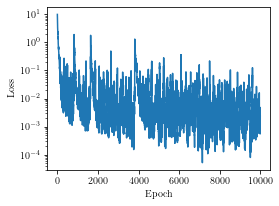

In [43]:
plt.figure(figsize=FIGSIZE)
plt.semilogy(epoch_arr_tot_tanh, loss_arr_tot_tanh)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.savefig(FIGPATH+"PDE_TANH_LOSS.pdf")

<ipython-input-52-cc77b48b28ff>:41: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cf = ax.pcolormesh(x, t, g, cmap=plt.get_cmap("jet"))
<ipython-input-52-cc77b48b28ff>:78: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cf = ax.pcolormesh(x, t, relative_error, cmap=plt.get_cmap("jet"),label="MSE")


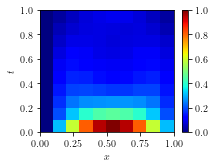

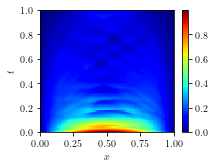

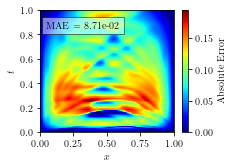

In [57]:
plot_pde(model=model_tanh, grid_size=11, fn="PDE_TANH_10x10")
plot_pde(model=model_tanh, grid_size=100, fn="PDE_TANH_100x100")
plot_error(model_tanh, np.linspace(0,1, 200), np.linspace(0,1,200), fn="PDE_TANH_ERR")